## CNN

#### ライブラリ

In [1]:
# オープンソース
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
from torch.nn import Conv2d
from torch.utils.data import DataLoader
# 自作
import utils

#### データ

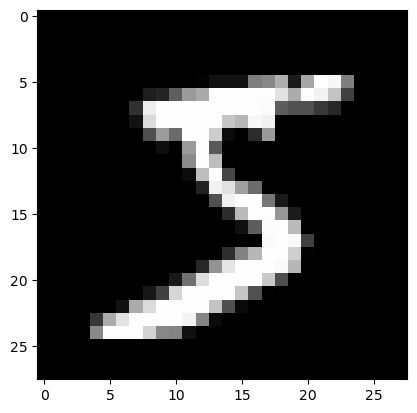

In [9]:
# MINISTデータセット(PIL形式)
dataset = torchvision.datasets.MNIST('~/data', train=True, download=True)
# PIL -> Tensorに変換
transform = transforms.ToTensor()
im, label = dataset[0]
im = transform(im)
# 3rank -> 2rankに変換(grayスケールなので)
im = im[0, :, :]

plt.imshow(im, cmap='gray')

#### スクラッチ実装(畳み込み層)

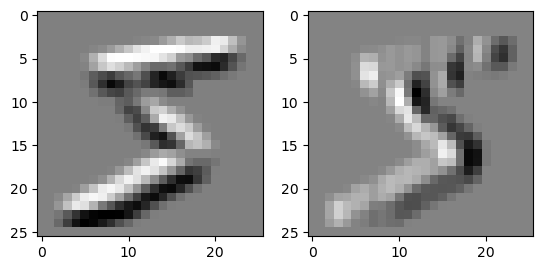

In [19]:
# filter適用関数
def apply_filter(im, filter):
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_w] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

# サンプルfilter
top_edge_filter = torch.tensor([[-1, -1, -1],
                                [0, 0, 0],
                                [1, 1, 1]])
left_edge_filter = torch.tensor([[-1, 0, 1],
                                [-1, 0, 1],
                                [-1, 0, 1]])

# filter適用
filterd_im_top = apply_filter(im, top_edge_filter)
filterd_im_left = apply_filter(im, left_edge_filter)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(filterd_im_top, cmap='gray')
ax[1].imshow(filterd_im_left, cmap='gray')

#### CNN構築

In [45]:
conv_model = nn.Sequential(
    # 1x28x28 -> 4x14x14
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14 -> 8x7x7
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7 -> 16x4x4
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4 -> 32x2x2
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> 128x1x1
    nn.Flatten(),
    # 128x1x1 -> 10x1x1
    nn.Linear(128, 10)
)

# モデルの入力サイズ
for params in conv_model.parameters():
    print(params)

Parameter containing:
tensor([[[[ 0.0554,  0.0546,  0.1634],
          [ 0.3042, -0.1917, -0.2144],
          [-0.2810,  0.0469,  0.3159]]],


        [[[-0.0570, -0.0355,  0.2567],
          [-0.0253,  0.3282, -0.3323],
          [-0.3123,  0.1178,  0.1281]]],


        [[[-0.1088, -0.1368,  0.2714],
          [ 0.2684,  0.2711, -0.2229],
          [ 0.1322, -0.3283,  0.2014]]],


        [[[-0.3057, -0.1565,  0.0140],
          [ 0.1174, -0.2156,  0.1506],
          [ 0.0460, -0.0403, -0.2343]]]], requires_grad=True)
Parameter containing:
tensor([ 0.2216, -0.0126,  0.2871,  0.3250], requires_grad=True)
Parameter containing:
tensor([[[[-0.0542, -0.1290,  0.0313],
          [ 0.1394,  0.0059,  0.0133],
          [-0.1501, -0.1085,  0.1018]],

         [[ 0.1616, -0.0548,  0.0953],
          [-0.0040, -0.0163,  0.0102],
          [-0.0828,  0.1226,  0.1382]],

         [[-0.0740,  0.0295,  0.0282],
          [-0.1098,  0.0651,  0.0521],
          [-0.0407,  0.0325,  0.0268]],

         

#### MNISTデータセットの学習

epoch: 0: train error: 0.16097343145117068, validation error: 0.1629135012626648, validation accuracy: 0.9495648734177216


epoch: 1: train error: 0.14364911704810698, validation error: 0.15446999013612542, validation accuracy: 0.9497626582278481


epoch: 2: train error: 0.13017766692761037, validation error: 0.15489531916719448, validation accuracy: 0.950751582278481


epoch: 3: train error: 0.11948488703541664, validation error: 0.11196935007973469, validation accuracy: 0.9636075949367089


epoch: 4: train error: 0.11248824980133759, validation error: 0.10631545467738392, validation accuracy: 0.9648931962025317


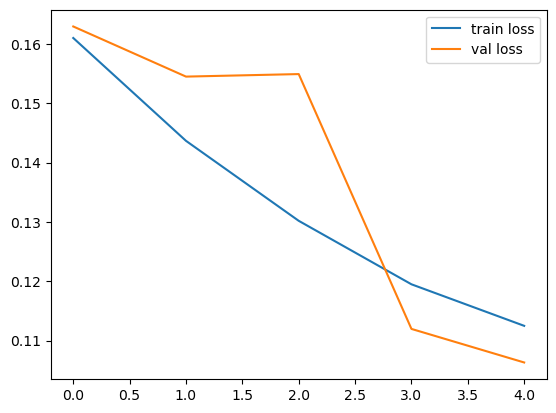

In [44]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
# DataLoader
train_dataset = torchvision.datasets.MNIST('~/data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('~/data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model
conv_model = conv_model.to(device)
# optimizer
opt = optim.SGD(conv_model.parameters(), lr=0.03)
# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=5)

# 結果のプロット
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.grid()